# Chapter 9: Design via Root Locus
---

In [1]:
import sys

if (path := "C:/Users/Tom/pycharm-projects/python-control") not in sys.path:
    sys.path.append(path)

import sympy as sp

from python_control import (
    s, K, 
    TransferFunction, 
    get_damping_ratio,
    is_second_order_approx
)
from python_control.design import (
    plot_step_responses,
    plot_ramp_responses,
    create_second_order_system
)
from python_control.design.root_locus import (
    design_unity_feedback,
    design_P_feedback,
    design_lag_feedback,
    design_PD_feedback,
    design_lead_feedback,
    design_PID_feedback,
    design_lag_lead_feedback,
    design_rate_feedback,
    design_minor_loop_feedback
)

## 9.2 : Improving Steady-State Error via Cascade Compensation

### Example 9.1 : Effect of an Ideal Integral Compensator

Given the system, operating with a damping ratio of 0.174, show that the addition of the ideal integral compensator reduces the steady-state error to zero for a step input without appreciably affecting transient response.

![closed-loop system for example 9.1: a. before compensation; b. after ideal integral compensation](./images/example_9-1.png)

**Steady-State Error and Gain of the Uncompensated System**

In [2]:
G_p = TransferFunction(1 / ((s + 1) * (s + 2) * (s + 10)))
zeta = 0.174

In [3]:
design_uc = design_P_feedback(
    G_p,
    damping_ratio=zeta, 
    name='uncompensated system'
)
print(design_uc.forward_gain)
print(design_uc.characteristics)

164.53222852221776
system type: type_0
steady-state error: 0.108
static error constant: 8.23
steady-state value: 0.892
dc-gain: 0.892
second-order approximation: True
natural frequency: 3.99
damping ratio: 0.174
rise time: 0.32
peak time: 0.884
settling time: 5.28
percent overshoot: 54


**Steady-State Error and Gain of the Compensated System**

The compensating network is chosen with a pole at the origin to increase the system type and a zero at -0.1, close to the compensator pole, so that the angular contribution of the compensator evaluated at the original, dominant, second-order poles is approximately zero. Thus, the original, dominant, second-order closed-loop poles are still approximately on the new root locus.

In [4]:
KG_c = TransferFunction(K * (s + 0.1) / s)  # compensator

In [5]:
fbsys_pi, K_pi = design_unity_feedback(
    KG_c, G_p, 
    damping_ratio=zeta, 
    name='PI-compensated system'
)

e_oo, *_ = fbsys_pi.steady_state_error(1 / s)

float(e_oo), K_pi

(0.0, 158.09700532412074)

**Comparison of the Uncompensated Response with the Ideal Integral Compensated Response and with the Response of the Second-Order System Approximation**

In [6]:
second_order_system = create_second_order_system(
    dominant_pole=fbsys_pi.dominant_pole_pair[0],
    name='second-order system'
)

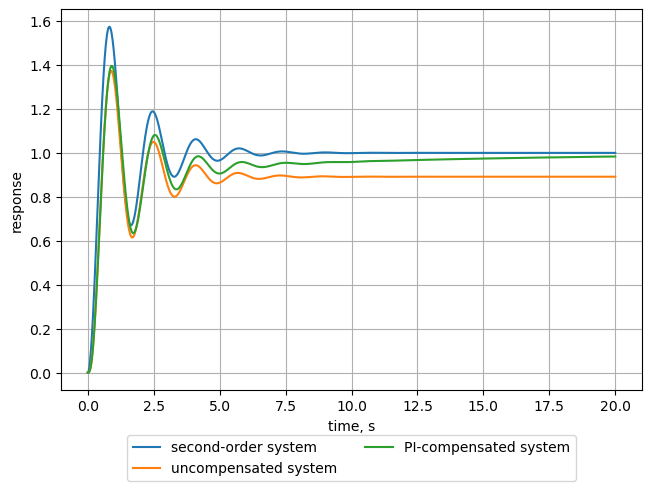

In [7]:
plot_step_responses(design_uc.feedback_system, fbsys_pi, second_order_system, upper_limit=20)

### Example 9.2 : Lag Compensator Design

Compensate the system in example 9.1 to improve the steady-state error by a factor of 10 if the system is operating with a damping ratio of 0.174.

**Steady-State Error and Gain of the Compensated System**

In [8]:
design_lag = design_lag_feedback(
    design_uc.feedback_system,
    e_oo_reduction_factor=10,
    compensator_pole=-0.01,
    damping_ratio=zeta,
    name='lag-compensated system'
)
print(design_lag.forward_gain)
print(design_lag.characteristics)

158.02008080567168
system type: type_0
steady-state error: 0.0113
static error constant: 87.7
steady-state value: 0.989
dc-gain: 0.989
second-order approximation: True
natural frequency: 3.89
damping ratio: 0.174
rise time: 0.351
peak time: 0.904
settling time: 14.9
percent overshoot: 41.2


**Comparison of the Uncompensated Response with the Lag Compensated Response**

In [9]:
second_order_system = create_second_order_system(
    dominant_pole=design_lag.feedback_system.dominant_pole_pair[0],
    name='second-order system'
)

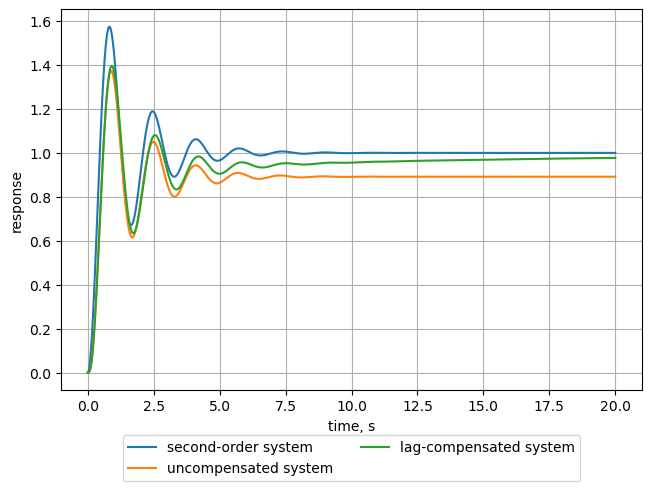

In [10]:
plot_step_responses(design_uc.feedback_system, design_lag.feedback_system, second_order_system, upper_limit=20)

## 9.3 : Improving Transient Response via Cascade Compensation

### Example 9.3 : Ideal Derivative Compensator Design

Given the system below, design an ideal derivative compensator to yield a 16% overshoot, with a threefold reduction in settling time.

![feedback control system for example 9.3](./images/example_9-3.png)

In [11]:
G_p = TransferFunction(1 / (s * (s + 4) * (s + 6)))
percent_overshoot = 16
zeta = get_damping_ratio(percent_overshoot)

**Settling Time and Gain of the Uncompensated System**

In [12]:
design_uc = design_P_feedback(
    G_p,
    damping_ratio=zeta,
    name='uncompensated system'
)
print(design_uc.forward_gain)
print(design_uc.characteristics)

43.3751465611198
system type: type_1
steady-state error: 0.553
static error constant: 1.81
steady-state value: 1
dc-gain: 1
second-order approximation: True
natural frequency: 2.39
damping ratio: 0.504
rise time: 0.733
peak time: 1.68
settling time: 3.51
percent overshoot: 15.1


With a forward gain $K$ of about 43.375, we get a feedback control system with 16% overshoot and a settling time of about 3.37 seconds.

**PD-Controller and PD-Compensated System**<br>
Determine the transfer function of the PD-controller to get a threefold reduction of the settling time.

In [13]:
design_pd = design_PD_feedback(
    settling_time=design_uc.characteristics.settling_time / 3,
    peak_time=None,
    damping_ratio=zeta,
    G_plant=G_p,
    name='PD-compensated system'
)
print(design_pd.forward_gain)
print(design_pd.controller_gains.K_p)
print(design_pd.controller_gains.K_d)

[12464 | python_control.design.root_locus | DEBUG] dominant pole: (-3.414957749370204+5.854258809208617j)
[12464 | python_control.design.root_locus | DEBUG] open-loop transfer function angle before compensation: 89.2752603894445
[12464 | python_control.design.root_locus | DEBUG] compensator zero: -3.3409027389882846
[12464 | python_control.design.root_locus | DEBUG] angular contribution of compensator zero: 90.7247396105555
[12464 | python_control.design.root_locus | DEBUG] open-loop transfer function angle after compensation: 180.00000000000006


43.58569190265003
145.615557458263
43.58569190265


In [14]:
design_pd.controller.expr

43.58569190265*s + 145.615557458263

In [15]:
print(design_pd.characteristics)

system type: type_1
steady-state error: 0.165
static error constant: 6.07
steady-state value: 1
dc-gain: 1
second-order approximation: True
natural frequency: 6.78
damping ratio: 0.504
rise time: 0.253
peak time: 0.548
settling time: 1.29
percent overshoot: 13.7


With a forward gain $K$ of about 46.45, we get a feedback control system with 16% overshoot and a settling time of about 1.14 seconds using a PD-controller.

**Comparison of the Uncompensated Response with the Ideal Derivative (PD) Compensated Response and Second-Order System Unit-Step Response**

In [16]:
second_order_system = create_second_order_system(
    dominant_pole=design_pd.feedback_system.dominant_pole_pair[0],
    name='second-order system'
)

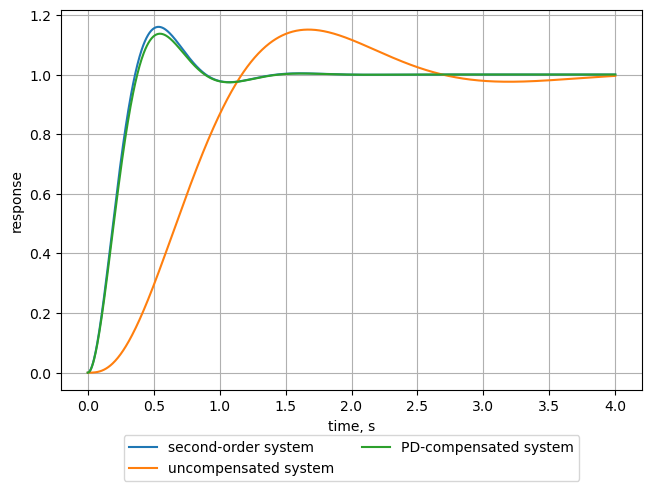

In [17]:
plot_step_responses(
    design_uc.feedback_system,
    design_pd.feedback_system,
    second_order_system,
    upper_limit=4
)

### Example 9.4 : Lead Compensator Design

Design three lead compensators for the system in example 9.3 that will reduce the settling time by a factor of 2 while maintaining 30% overshoot. Compare the system characteristics between the three designs.

In [18]:
G_p = TransferFunction(1 / (s * (s + 4) * (s + 6)))
percent_overshoot = 30
zeta = get_damping_ratio(percent_overshoot)

**Uncompensated System**

In [19]:
design_uc = design_P_feedback(
    G_p, zeta,
    name='uncompensated system'
)
print(design_uc.forward_gain)
print(design_uc.characteristics)

63.22775812820211
system type: type_1
steady-state error: 0.38
static error constant: 2.63
steady-state value: 1
dc-gain: 1
second-order approximation: True
natural frequency: 2.81
damping ratio: 0.358
rise time: 0.54
peak time: 1.34
settling time: 4.01
percent overshoot: 28


**Lead Compensator Design 1**

In [20]:
design_lead1 = design_lead_feedback(
    settling_time=design_uc.characteristics.settling_time / 2,
    peak_time=None,
    damping_ratio=zeta,
    G_plant=G_p,
    compensator_zero=-5,
    name='lead-compensated 1'
)
print(design_lead1.forward_gain)
print(design_lead1.characteristics)

[12464 | python_control.design.root_locus | DEBUG] dominant pole: (-1.9963208340131138+5.209110076082758j)
[12464 | python_control.design.root_locus | DEBUG] open-loop transfer function angle before compensation: 127.61612091881878
[12464 | python_control.design.root_locus | DEBUG] LEAD compensator zero: -5, pole: -40.79144948776818
[12464 | python_control.design.root_locus | DEBUG] angular contribution of compensator zero: 60.03137348054056
[12464 | python_control.design.root_locus | DEBUG] angular contribution of compensator pole: 7.647494399359348
[12464 | python_control.design.root_locus | DEBUG] open-loop transfer function angle after compensation: 180.0


1331.5896785706675
system type: type_1
steady-state error: 0.147
static error constant: 6.8
steady-state value: 1
dc-gain: 1
second-order approximation: True
natural frequency: 5.58
damping ratio: 0.358
rise time: 0.251
peak time: 0.62
settling time: 2.08
percent overshoot: 30.5


**Lead Compensator Design 2**

In [21]:
design_lead2 = design_lead_feedback(
    settling_time=design_uc.characteristics.settling_time / 2,
    peak_time=None,
    damping_ratio=zeta,
    G_plant=G_p,
    compensator_zero=-2,
    name='lead-compensated 2'
)
print(design_lead2.forward_gain)
print(design_lead2.characteristics)

[12464 | python_control.design.root_locus | DEBUG] dominant pole: (-1.9963208340131138+5.209110076082758j)
[12464 | python_control.design.root_locus | DEBUG] open-loop transfer function angle before compensation: 127.61612091881878
[12464 | python_control.design.root_locus | DEBUG] LEAD compensator zero: -2, pole: -8.766437291460736
[12464 | python_control.design.root_locus | DEBUG] angular contribution of compensator zero: 89.95953231069319
[12464 | python_control.design.root_locus | DEBUG] angular contribution of compensator pole: 37.57565322951199
[12464 | python_control.design.root_locus | DEBUG] open-loop transfer function angle after compensation: 180.0


335.44034221593546
system type: type_1
steady-state error: 0.314
static error constant: 3.19
steady-state value: 1
dc-gain: 1
second-order approximation: False
rise time: 0.325
peak time: 0.722
settling time: 1.73
percent overshoot: 14.3


**Lead Compensator Design 3**

In [22]:
design_lead3 = design_lead_feedback(
    settling_time=design_uc.characteristics.settling_time / 2,
    peak_time=None,
    damping_ratio=zeta,
    G_plant=G_p,
    compensator_zero=-4,
    name='lead-compensated 3'
)
print(design_lead3.forward_gain)
print(design_lead3.characteristics)

[12464 | python_control.design.root_locus | DEBUG] dominant pole: (-1.9963208340131138+5.209110076082758j)
[12464 | python_control.design.root_locus | DEBUG] open-loop transfer function angle before compensation: 127.61612091881878
[12464 | python_control.design.root_locus | DEBUG] LEAD compensator zero: -4, pole: -19.49566579748608
[12464 | python_control.design.root_locus | DEBUG] angular contribution of compensator zero: 68.96080940604321
[12464 | python_control.design.root_locus | DEBUG] angular contribution of compensator pole: 16.576930324862005
[12464 | python_control.design.root_locus | DEBUG] open-loop transfer function angle after compensation: 180.0


669.1767914125721
system type: type_1
steady-state error: 0.175
static error constant: 5.72
steady-state value: 1
dc-gain: 1
second-order approximation: True
natural frequency: 5.58
damping ratio: 0.358
rise time: 0.264
peak time: 0.654
settling time: 2
percent overshoot: 28.9


**Comparison between Uncompensated System and Lead Compensator Designs**

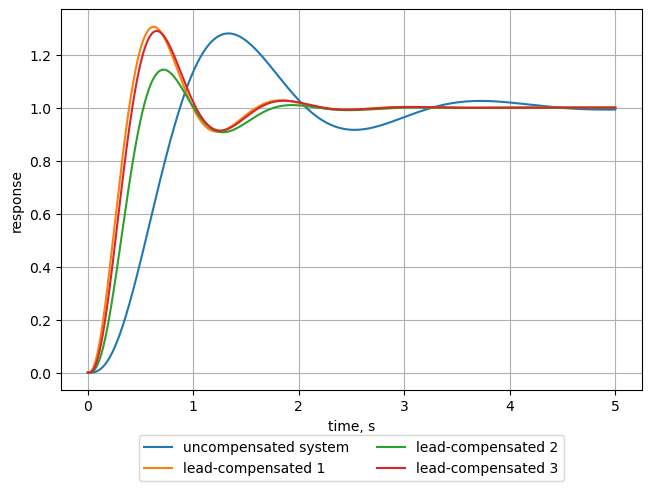

In [23]:
plot_step_responses(
    design_uc.feedback_system,
    design_lead1.feedback_system,
    design_lead2.feedback_system,
    design_lead3.feedback_system,
    upper_limit=5
)

## 9.4 : Improving Steady-State Error and Transient Response

### Example 9.5 : PID Controller Design 

For the system below, design a PID controller so that the system can operate with a peak time that is two-thirds that of the uncompensated system at 20% overshoot and with zero steady-state error for a step input.

![uncompensated feedback control system for example 9.5](./images/example_9-5.png)

**Uncompensated System**

In [24]:
G_p = TransferFunction((s + 8) / ((s + 3) * (s + 6) * (s + 10)))
zeta = get_damping_ratio(percent_overshoot=20)

In [25]:
design_uc = design_P_feedback(G_p, zeta, name='uncompensated system')
print(design_uc.forward_gain)
print(design_uc.characteristics)

121.55395211140856
system type: type_0
steady-state error: 0.156
static error constant: 5.4
steady-state value: 0.844
dc-gain: 0.844
second-order approximation: True
natural frequency: 11.9
damping ratio: 0.456
rise time: 0.129
peak time: 0.297
settling time: 0.718
percent overshoot: 20.7


**PID-compensated System**<br>
First, a compensated system with a PD-controller is designed to meet the transient response specifications. Then, an integral compensator is added to this PD-compensated system to yield the required steady-state error.

We can decide where the zero of the integral compensator should be placed on the real-axis of the complex plane. This should be close to the origin. 

In [26]:
design_pid = design_PID_feedback(
    settling_time=None,
    peak_time=design_uc.characteristics.peak_time * 2 / 3,
    damping_ratio=zeta,
    G_plant=G_p,
    integrator_zero=-0.5,
    name='PID-compensated system'
)
print(design_pid.forward_gain)
print(
    design_pid.controller_gains.K_p, 
    design_pid.controller_gains.K_i,
    design_pid.controller_gains.K_d
)
print(design_pid.characteristics)

[12464 | python_control.design.root_locus | DEBUG] dominant pole: (-8.141218072205284+15.891505157990872j)
[12464 | python_control.design.root_locus | DEBUG] open-loop transfer function angle before compensation: 161.57930985297364
[12464 | python_control.design.root_locus | DEBUG] compensator zero: -55.85531082814196
[12464 | python_control.design.root_locus | DEBUG] angular contribution of compensator zero: 18.42069014702636
[12464 | python_control.design.root_locus | DEBUG] open-loop transfer function angle after compensation: 179.99999999999994


4.617313397563376
260.210131710629 128.950737505923 4.61731339756338
system type: type_1
steady-state error: 0.174
static error constant: 5.73
steady-state value: 1
dc-gain: 1
second-order approximation: True
natural frequency: 16.5
damping ratio: 0.456
rise time: 0.0951
peak time: 0.194
settling time: 2.58
percent overshoot: 14.2


Note that by adding the integral control action, the system type goes from type 0 to type 1. The steady-state error of a type 1 system is determined by a unit-ramp input ($1/s^2$). When we look at the steady-state error for a unit-step input, we can see it is zero:

In [27]:
print(design_pid.feedback_system.steady_state_error(1 / s).e_oo)

0


**Comparison between PID-, PD-Compensated Systems and Uncompensated System**

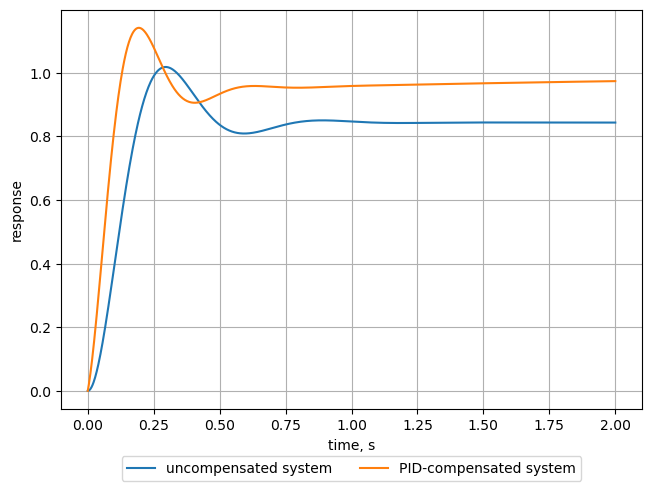

In [28]:
plot_step_responses(
    design_uc.feedback_system,
    design_pid.feedback_system,
    upper_limit=2.0
)

### Example 9.6 : Lag-Lead Compensator Design

For the system below, design a lag-lead compensator so that the system will operate with 20% overshoot and a twofold reduction in settling time. Further, the compensated system will exhibit a tenfold improvement in steady-state error for a ramp input.

![uncompensated system for example 9.6](./images/example_9-6.png)

**Uncompensated System**

In [29]:
G_p = TransferFunction(1 / (s * (s + 6) * (s + 10)))
zeta = get_damping_ratio(percent_overshoot=20)

In [30]:
design_uc = design_P_feedback(
    G_plant=G_p, 
    damping_ratio=zeta, 
    name='uncompensated system'
)
print(design_uc.forward_gain)
print(design_uc.characteristics)

192.0730938096778
system type: type_1
steady-state error: 0.312
static error constant: 3.2
steady-state value: 1
dc-gain: 1
second-order approximation: True
natural frequency: 3.93
damping ratio: 0.456
rise time: 0.423
peak time: 0.991
settling time: 2.26
percent overshoot: 18.9


**Lag-Lead Compensated System**<br>
First, a lead-compensated system is designed to meet the transient response specifications. Then, a lag compensator is added to this lead-compensated system to yield the required steady-state error.

In [31]:
design_ll = design_lag_lead_feedback(
    settling_time=design_uc.characteristics.settling_time / 2,
    peak_time=None,
    damping_ratio=zeta,
    e_oo_reduction=10.0,
    G_plant=G_p,
    lead_compensator_zero=-6,
    lag_compensator_pole=-0.01,
    name='lag-lead system'
)
print(design_ll.forward_gain)
print(design_ll.characteristics)

[12464 | python_control.design.root_locus | DEBUG] dominant pole: (-3.5359416006066366+6.902091761457238j)
[12464 | python_control.design.root_locus | DEBUG] open-loop transfer function angle before compensation: 125.64357039006467
[12464 | python_control.design.root_locus | DEBUG] LEAD compensator zero: -6, pole: -27.611280301559958
[12464 | python_control.design.root_locus | DEBUG] angular contribution of compensator zero: 70.35334975676513
[12464 | python_control.design.root_locus | DEBUG] angular contribution of compensator pole: 15.996920146829792
[12464 | python_control.design.root_locus | DEBUG] open-loop transfer function angle after compensation: 180.00000000000003


1824.637150725945
system type: type_1
steady-state error: 0.0151
static error constant: 66.1
steady-state value: 1
dc-gain: 1
second-order approximation: True
natural frequency: 7.68
damping ratio: 0.456
rise time: 0.209
peak time: 0.5
settling time: 1.07
percent overshoot: 20.9


**Comparison between Lag-Lead-Compensated System, Lead-Compensated System and Uncompensated System**

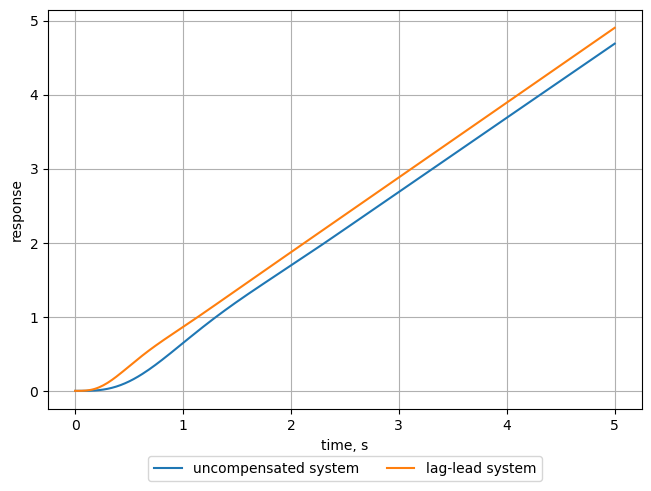

In [32]:
plot_ramp_responses(
    design_uc.feedback_system,
    design_ll.feedback_system,
    upper_limit=5.0
)

## 9.5 : Feedback Compensation

### Example 9.7 : Compensating Zero via Rate Feedback

For the uncompensated system shown below, design rate feedback compensation to reduce the settling time by a factor of 4 while continuing to operate the system with 20% overshoot.

![system for example 9.7](./images/example_9-7.png)

**Uncompensated System**

In [33]:
zeta = get_damping_ratio(percent_overshoot=20)
G_p = TransferFunction(1 / (s * (s + 5) * (s + 15)))

In [34]:
design_uc = design_P_feedback(
    G_plant=G_p, 
    damping_ratio=zeta,
    name='uncompensated system'
)
print(design_uc.forward_gain)
print(design_uc.characteristics)

257.80770827189986
system type: type_1
steady-state error: 0.291
static error constant: 3.44
steady-state value: 1
dc-gain: 1
second-order approximation: True
natural frequency: 3.97
damping ratio: 0.456
rise time: 0.409
peak time: 0.951
settling time: 2.21
percent overshoot: 19.3


**System with Rate Feedback Compensation**

The block diagram of the rate feedback compensated system is shown below:

![system with rate feedback compensation](./images/example_9-7b.png)

The feedback paths of the major loop and the minor loop can be added together in a single feedback-loop:

![equivalent compensated system](./images/example_9-7c.png)

The transfer function of the feedback path now has the form of a PD-controller.

In [35]:
design_cs = design_rate_feedback(
    settling_time=design_uc.characteristics.settling_time / 4,
    peak_time=None,
    damping_ratio=zeta,
    G_plant=G_p,
    name='rate feedback compensated system'
)
print(design_cs.forward_gain)
print(design_cs.feedback_gain)
print(design_cs.characteristics)

[12464 | python_control.design.root_locus | DEBUG] dominant pole: (-7.233159454917578+14.118991748768714j)
[12464 | python_control.design.root_locus | DEBUG] open-loop transfer function angle before compensation: 82.70122711694
[12464 | python_control.design.root_locus | DEBUG] compensator zero: -5.424782249191317
[12464 | python_control.design.root_locus | DEBUG] angular contribution of compensator zero: 97.29877288306
[12464 | python_control.design.root_locus | DEBUG] open-loop transfer function angle after compensation: 180.0


1392.6312158754592
0.18433919631503576
system type: type_1
steady-state error: 0.238
static error constant: 4.2
steady-state value: 1
dc-gain: 1
second-order approximation: False
rise time: 0.344
peak time: 3.96
settling time: 3.96
percent overshoot: -3.77e-08


**Comparison between the Unit Step Response of the Uncompensated System and the Compensated System**

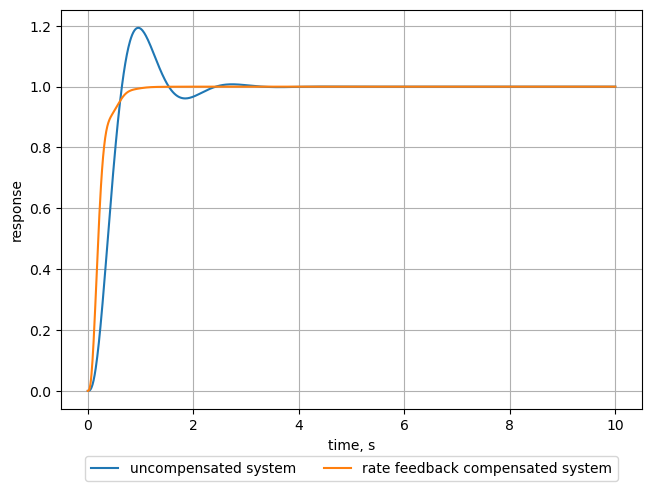

In [36]:
plot_step_responses(
    design_uc.feedback_system,
    design_cs.feedback_system
)

### Example 9.8 : Minor-Loop Feedback Compensation

For the same uncompensated system, design minor-loop feedback compensation to yield a damping ratio of 0.8 for the minor loop and a damping ratio of 0.6 for the closed loop system.

The block diagram of the feedback system with minor-loop feedback compensation is shown below.

![feedback compensated system for example 9.8](./images/example_9-8.png)

**Uncompensated System**

In [37]:
G_p = TransferFunction(1 / (s * (s + 5) * (s + 15)))
design_uc = design_P_feedback(
    G_plant=G_p, 
    damping_ratio=0.6,
    name='uncompensated system'
)
print(design_uc.forward_gain)
print(design_cs.characteristics)

177.28579024636255
system type: type_1
steady-state error: 0.238
static error constant: 4.2
steady-state value: 1
dc-gain: 1
second-order approximation: False
rise time: 0.344
peak time: 3.96
settling time: 3.96
percent overshoot: -3.77e-08


**Minor-Loop Feedback Compensated System** 

In [38]:
K_f = sp.Symbol('K_f', real=True, positive=True)
H_mnl = TransferFunction(K_f * s)

design_mjl, design_mnl = design_minor_loop_feedback(
    damping_ratio_minor=0.8,
    damping_ratio_major=0.6,
    G_plant=G_p,
    H_mnl=(H_mnl, K_f),
    name='compensated system'
)
print(design_mjl.forward_gain)
print(design_mjl.characteristics)

624.3381986449643
system type: type_1
steady-state error: 0.25
static error constant: 4
steady-state value: 1
dc-gain: 1
second-order approximation: False
rise time: 0.301
peak time: 0.649
settling time: 0.897
percent overshoot: 6.61


**Comparison between the Unit Step Response of the Uncompensated System and the Compensated System**

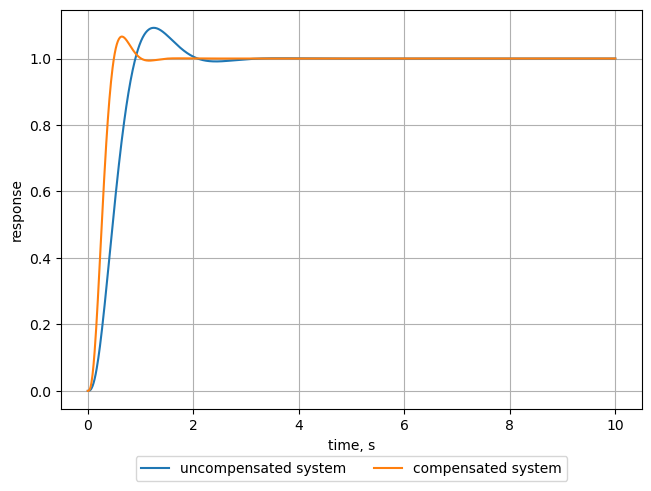

In [39]:
plot_step_responses(
    design_uc.feedback_system,
    design_mjl.feedback_system
)